In [1]:
import os
import re
import sys
sys.path.append('../train/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
import seaborn as sns
from scipy import stats

from util import array2mat, mat2array
from validate import evaluate

/home/liminghong/miniconda3/envs/see/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
v19_anno = pd.read_csv('/data/liminghong/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\w*)')[1]
v19_anno['transcript_name'] = v19_anno['info'].str.extract(r'(transcript_name ")(\S*)(")')[1]


transcript_info = v19_anno[v19_anno['type']=='transcript'].copy()
transcript_info = transcript_info.set_index('transcript_name')
transcript_info = transcript_info.drop(labels='info', axis=1)
transcript_info = transcript_info.drop(labels='type', axis=1)

exons = v19_anno[(v19_anno['type']=='exon')&(v19_anno['transcript_name'].isin(transcript_info.index))].copy()
exons['blockSizes'] = exons['end'] - exons['start']
exons['blockStarts'] = exons['start']
exons_group = exons.groupby("transcript_name")
transcript_info['blockCount'] = exons_group['blockStarts'].count()
transcript_info['blockSizes'] = exons_group['blockSizes'].apply(list)
transcript_info['blockStarts'] = exons_group['blockStarts'].apply(list)
transcript_info

,chrom,start,end,strand,gene_name,blockCount,blockSizes,blockStarts
transcript_name,,,,,,,,
DDX11L1-002,chr1,11869,14409,+,DDX11L1,3,"[358, 108, 1188]","[11869, 12613, 13221]"
DDX11L1-201,chr1,11872,14412,+,DDX11L1,3,"[355, 108, 1187]","[11872, 12613, 13225]"
DDX11L1-202,chr1,11874,14409,+,DDX11L1,4,"[353, 126, 252, 748]","[11874, 12595, 13403, 13661]"
DDX11L1-001,chr1,12010,13670,+,DDX11L1,6,"[47, 48, 84, 77, 153, 217]","[12010, 12179, 12613, 12975, 13221, 13453]"
WASH7P-202,chr1,14363,29370,-,WASH7P,12,"[49, 153, 111, 146, 140, 131, 201, 158, 43, 10...","[29321, 24738, 18268, 17915, 17602, 17233, 168..."
...,...,...,...,...,...,...,...,...
MT-ND6-201,chrM,14149,14673,-,MT,1,[524],[14149]
MT-TE-201,chrM,14674,14742,-,MT,1,[68],[14674]
MT-CYB-201,chrM,14747,15887,+,MT,1,[1140],[14747]


In [3]:
def show_by_cell_type(eval_set, preds, cell_type, gene_name):
    _pred, _target = None, None
    num = 0
    for i in range(len(preds)):
        pred = preds[i]
        if cell_type and eval_set[i]['cell_type'] != cell_type:
            continue
        pred['predict'][pred['predict']<0] = 0
        num += 1
        if _pred is None:
            _pred = pred['predict'].copy()
            _target = eval_set[i]['scHiC'][gene_name].copy().astype(float)
        else:
            _pred += pred['predict']
            _target += eval_set[i]['scHiC'][gene_name].copy().astype(float)
    return _pred/num, _target/num

def _draw(mat):
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    mat = mat.copy()
    row, col = np.diag_indices_from(mat)
    # mat[row,col] = 0
    sns.heatmap(mat, cmap='Reds_r', square=True)

In [4]:
dir_path = "/data/liminghong/sclab/sclab/random_test/tmp"

def read_log(file_path: str):
    with open(file_path, 'r') as file:
        content = file.readlines()

    best_accuracy, best_epoch = 0, 0
    for data in content:
        if "Epoch" not in data:
            continue
        epoch_match = re.search(r"Epoch\[(\d+)\]", data)
        test_accuracy_match = re.search(r"test_accuracy: (\d+\.\d+)", data)
        epoch, accuracy = int(epoch_match.group(1)), float(test_accuracy_match.group(1))

        if accuracy >= best_accuracy:
            best_epoch = epoch
            best_accuracy = accuracy
    return best_epoch

for root, dirs, files in os.walk(dir_path):
    for directory in dirs:
        print(directory)
        if os.path.exists(os.path.join(root, directory, "evaluate.npy")):
            continue

        best_epoch = read_log(os.path.join(root, directory, "exp.log"))
        chrom, start, end = directory.split(sep="_")
        bins = int((int(end) - int(start)) / 10000)
        output_size = (bins * (bins + 1)) / 2

        evaluate(
            eval_file="/data/liminghong/sclab/sclab/random_test/eval_dataset.npy",
            model_file=os.path.join(root, directory, "model_epoch_{}.pth".format(best_epoch)),
            gene_name=directory,
            output_size=output_size,
            output_file=os.path.join(root, directory, "evaluate.npy"),
        )

chr6_152230000_152590000
chr5_41480000_41840000
chr21_20260000_20500000
chr2_176640000_176840000
chr4_69390000_69680000
chr13_71100000_71370000
chr17_14790000_15060000
chr20_51150000_51590000
chr14_50770000_50990000
chr1_227020000_227410000
chr12_118040000_118290000
chr7_70290000_70540000


In [5]:
H3K9me3 = pyBigWig.open('/data/liminghong/sclab/sclab/random_test/source/ENCFF706IWZ.bigWig')

dir_path = "/data/liminghong/sclab/sclab/random_test/tmp"
eval_set = np.load('/data/liminghong/sclab/sclab/random_test/eval_dataset.npy', allow_pickle=True)
result, pvalues = pd.DataFrame(), pd.DataFrame()
for root, dirs, files in os.walk(dir_path):
    for directory in dirs:
        print(directory)
        preds = np.load(os.path.join(root, directory, "evaluate.npy"), allow_pickle=True)

        _stats, _pvalues = {}, {}
        _zero_ratios, _diagonal_count_ratios = [], []
        for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
            _pred, _target = show_by_cell_type(eval_set, preds, cell_type, directory)
            _pred, _target = array2mat(_pred), array2mat(_target)
            _zero_ratios.append(np.count_nonzero(_target == 0) / _target.size)
            _diagonal_count_ratios.append(np.trace(_target) / np.sum(_target))
            np.fill_diagonal(_pred, 0)
            np.fill_diagonal(_target, 0)
            # _draw(_pred)
            # _draw(_target)
            _pred, _target = mat2array(_pred), mat2array(_target)

            _stat, _p = stats.pearsonr(_pred, _target)
            # print('{}: stat={} pvalue={}'.format(cell_type, _stat, _p))
            _stats[cell_type], _pvalues[cell_type] = [_stat], [_p]

        _stats = pd.DataFrame(_stats, index=[directory])
        _stats.loc[:, "zero ratio"] = np.array(_zero_ratios).mean()
        _stats.loc[:, "diagonal count ratio"] = np.array(_diagonal_count_ratios).mean()
        _chrom, _start, _end = directory.split("_")
        _stats.loc[:, "transcript"] = ", ".join(v19_anno[
            (v19_anno["type"]=="gene")&
            (v19_anno["chrom"]==_chrom)&
            (v19_anno["start"]<int(_end))&
            (v19_anno["end"]>int(_start))
        ]["transcript_name"].unique())
        _stats.loc[:, "H3K9me3"] = H3K9me3.stats(_chrom, int(_start), int(_end), type="mean", nBins=1)[0]
        result = pd.concat([result, _stats])

        _pvalues = pd.DataFrame(_pvalues, index=[directory])
        pvalues = pd.concat([pvalues, _pvalues])

display(result)
display(pvalues)
result.to_csv('table_file/domain.csv')

chr6_152230000_152590000
chr5_41480000_41840000
chr21_20260000_20500000
chr2_176640000_176840000
chr4_69390000_69680000
chr13_71100000_71370000
chr17_14790000_15060000
chr20_51150000_51590000
chr14_50770000_50990000
chr1_227020000_227410000
chr12_118040000_118290000
chr7_70290000_70540000


,Astro,Endo,ODC,OPC,zero ratio,diagonal count ratio,transcript,H3K9me3
chr6_152230000_152590000,0.849275,0.632426,0.682593,0.753741,0.522762,0.743602,"ESR1, SYNE1",0.337982
chr5_41480000_41840000,0.739802,0.578743,0.607762,0.763833,0.519290,0.751867,"PLCXD3, CTD-2122P11.1, OXCT1",0.397074
chr21_20260000_20500000,0.747832,0.615058,0.427989,0.661505,0.471354,0.788380,"AL157359.4, AL157359.3, AP000431.1",0.440891
chr2_176640000_176840000,0.831511,0.596559,0.620898,0.837507,0.402500,0.774058,"EXTL2P1, AC016751.3, AC016751.2, KIAA1715",0.365799
chr4_69390000_69680000,0.680082,0.396701,0.436971,0.666158,0.609394,0.780668,"UGT2B17, RP11-1267H10.2, RP11-1267H10.1, RP11-...",0.366040
chr13_71100000_71370000,0.780555,0.582450,0.656274,0.777198,0.588477,0.784533,,0.361213
chr17_14790000_15060000,0.844728,0.649315,0.646112,0.763939,0.478738,0.786207,"AC005863.2, RPL23AP76, AC005772.2, CDRT7, CDRT8",0.541809
chr20_51150000_51590000,0.768077,0.575671,0.681287,0.777312,0.545196,0.740856,"RP4-723E3.1, RP4-715N11.2, RP11-80K6.2, RPL36P...",0.439870
chr14_50770000_50990000,0.835241,0.584887,0.621869,0.794648,0.320248,0.752527,"L2HGDH, ATP5S, RP11-247L20.4, CDKL1, RP11-247L...",0.245649
chr1_227020000_227410000,0.709960,0.440637,0.554330,0.750404,0.483563,0.731049,"PSEN2, ADCK3, RP5-1087E8.2, CDC42BPA, RP5-1087...",0.255891


,Astro,Endo,ODC,OPC
chr6_152230000_152590000,2.308027e-186,1.106032e-75,1.650249e-92,3.560458e-123
chr5_41480000_41840000,2.226976e-116,8.239942e-61,1.697762e-68,2.188336e-128
chr21_20260000_20500000,5.940878e-55,1.309680e-32,8.591143e-15,3.982745e-39
chr2_176640000_176840000,5.213576e-55,1.245716e-21,8.941137e-24,1.679218e-56
chr4_69390000_69680000,2.369900e-60,7.585165e-18,1.038148e-21,4.042903e-57
chr13_71100000_71370000,9.876360e-79,1.032220e-35,6.313973e-48,1.207572e-77
chr17_14790000_15060000,4.052268e-104,1.252011e-46,4.823314e-46,1.576100e-73
chr20_51150000_51590000,1.837487e-193,1.890857e-88,5.213001e-136,4.564889e-201
chr14_50770000_50990000,3.866225e-67,1.291234e-24,1.804516e-28,2.475281e-56
chr1_227020000_227410000,1.356187e-120,2.190637e-38,4.874381e-64,4.861807e-142


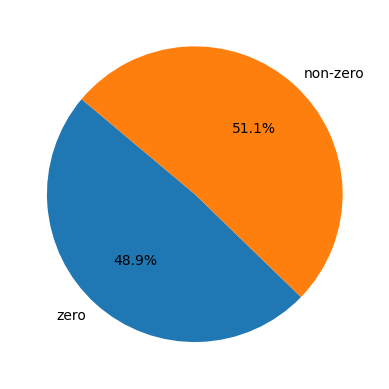

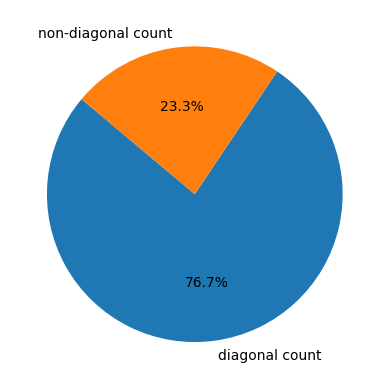

In [6]:
labels = ['zero', 'non-zero']
sizes = [result["zero ratio"].mean(), 1-result["zero ratio"].mean()]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.savefig('./figure_file/Sparse rate.pdf', format='pdf', bbox_inches='tight')
plt.show()

labels = ['diagonal count', 'non-diagonal count']
sizes = [result["diagonal count ratio"].mean(), 1-result["diagonal count ratio"].mean()]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.savefig('./figure_file/The proportion of diagonal count.pdf', format='pdf', bbox_inches='tight')
plt.show()

0.022590140144498793 0.02095596825596416


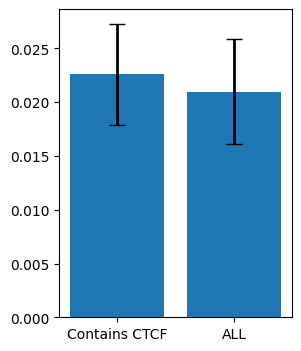

In [7]:
CTCF = pd.read_csv('/data/liminghong/sclab/sclab/random_test/source/ENCFF246XGW.hg19.bed', sep='\t', usecols=range(3), names=["chrom", "start", "end"])
resolution = 10000

have, all = [], []
for location in result.index:
    chrom, start, end = location.split("_")
    start, end = int(start), int(end)
    preds = np.load(os.path.join(dir_path, location, "evaluate.npy"), allow_pickle=True)
    _pred, _ = show_by_cell_type(eval_set, preds, None, location)
    _mat = array2mat(_pred)

    _boundary = CTCF[(CTCF["chrom"]==chrom)&(CTCF["start"]>=start)&(CTCF["end"]<end)].copy()
    _boundary_info = ((_boundary["start"] - start) / resolution).astype(int).values

    for i in _boundary_info:
        have.append(_mat[i].mean())
    all.append(_mat.flatten().mean())
have, all = np.array(have), np.array(all)
print(have.mean(), all.mean())

fig = plt.figure(figsize=(3, 4), facecolor='white')
x, y = ["Contains CTCF", "ALL"], [have.mean(), all.mean()]
plt.bar(x, y, yerr=[np.std(have), np.std(all)], error_kw={"elinewidth":2,"ecolor":"black","capsize":6})
plt.savefig('./figure_file/Interaction VS CTCF(domain).pdf', format='pdf', bbox_inches='tight')
plt.show()

In [8]:
eval_set = np.load('/data/liminghong/sclab/sclab/random_test/eval_dataset.npy', allow_pickle=True)
keep_diagonal_result, keep_diagonal_pvalues = pd.DataFrame(), pd.DataFrame()
for root, dirs, files in os.walk(dir_path):
    for directory in dirs:
        print(directory)
        preds = np.load(os.path.join(root, directory, "evaluate.npy"), allow_pickle=True)

        _stats, _pvalues = {}, {}
        for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
            _pred, _target = show_by_cell_type(eval_set, preds, cell_type, directory)

            _stat, _p = stats.pearsonr(_pred, _target)
            # print('{}: stat={} pvalue={}'.format(cell_type, _stat, _p))
            _stats[cell_type], _pvalues[cell_type] = [_stat], [_p]
        _stats = pd.DataFrame(_stats, index=[directory])
        keep_diagonal_result = pd.concat([keep_diagonal_result, _stats])
        _pvalues = pd.DataFrame(_pvalues, index=[directory])
        keep_diagonal_pvalues = pd.concat([keep_diagonal_pvalues, _pvalues])

display(keep_diagonal_result)
display(keep_diagonal_pvalues)
keep_diagonal_result.to_csv('table_file/domain(keep diagonal count).csv')

chr6_152230000_152590000
chr5_41480000_41840000
chr21_20260000_20500000
chr2_176640000_176840000
chr4_69390000_69680000
chr13_71100000_71370000
chr17_14790000_15060000
chr20_51150000_51590000
chr14_50770000_50990000
chr1_227020000_227410000
chr12_118040000_118290000
chr7_70290000_70540000


,Astro,Endo,ODC,OPC
chr6_152230000_152590000,0.995519,0.977631,0.992573,0.993125
chr5_41480000_41840000,0.993858,0.976515,0.993857,0.990397
chr21_20260000_20500000,0.994073,0.980720,0.995549,0.986092
chr2_176640000_176840000,0.994847,0.967896,0.994512,0.988989
chr4_69390000_69680000,0.989635,0.951393,0.990370,0.986435
chr13_71100000_71370000,0.990392,0.955343,0.992245,0.990041
chr17_14790000_15060000,0.992940,0.970710,0.994983,0.990040
chr20_51150000_51590000,0.993230,0.974157,0.993798,0.989891
chr14_50770000_50990000,0.993880,0.981221,0.993911,0.990652
chr1_227020000_227410000,0.994121,0.969891,0.993922,0.991174


,Astro,Endo,ODC,OPC
chr6_152230000_152590000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
chr5_41480000_41840000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
chr21_20260000_20500000,3.006855e-289,2.408010e-213,9.823559e-308,2.623708e-234
chr2_176640000_176840000,9.801471e-209,1.035987e-126,6.704112e-206,1.433493e-174
chr4_69390000_69680000,0.000000e+00,1.362023e-223,0.000000e+00,0.000000e+00
chr13_71100000_71370000,0.000000e+00,3.650887e-201,0.000000e+00,2.964394e-322
chr17_14790000_15060000,0.000000e+00,5.736897e-235,0.000000e+00,2.964394e-322
chr20_51150000_51590000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
chr14_50770000_50990000,3.565948e-242,2.090545e-181,1.882615e-242,3.596208e-219
chr1_227020000_227410000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


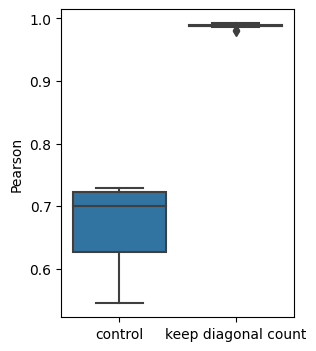

In [9]:
_result, _keep_diagonal_result = result[["Astro", "Endo", "ODC", "OPC"]], keep_diagonal_result[["Astro", "Endo", "ODC", "OPC"]]
_result, _keep_diagonal_result = _result.mean(axis=1), _keep_diagonal_result.mean(axis=1)
_result, _keep_diagonal_result = pd.melt(_result.to_frame()), pd.melt(_keep_diagonal_result.to_frame())
_result["variable"], _keep_diagonal_result["variable"] = "control", "keep diagonal count"

fig = plt.figure(figsize=(3, 4), facecolor='white')
sns.boxplot(data=pd.concat([_result, _keep_diagonal_result]), x="variable", y="value")
plt.xlabel("")
plt.ylabel("Pearson")
plt.savefig('./figure_file/The impact of retaining diagonal count.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
eval_set = np.load('/data/liminghong/sclab/sclab/eval_dataset.npy', allow_pickle=True)
marker_gene_result, marker_gene_pvalues = pd.DataFrame(), pd.DataFrame()
for gene_name in [
    "PDGFRA", "PTPRZ1", "VCAN",  # OPC
    "SLC1A2", "SLC1A3", "GPM6A",  # Astro
    "MBP", "QKI", "DOCK10", "PIP4K2A",  # ODC
]:
    preds = np.load(os.path.join("/data/liminghong/sclab/sclab/tmp", gene_name, "evaluate.npy"), allow_pickle=True)

    _stats, _pvalues = {}, {}
    for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
        _pred, _target = show_by_cell_type(eval_set, preds, cell_type, gene_name)
        _pred, _target = array2mat(_pred), array2mat(_target)
        np.fill_diagonal(_pred, 0)
        np.fill_diagonal(_target, 0)

        _pred, _target = mat2array(_pred), mat2array(_target)

        _stat, _p = stats.pearsonr(_pred, _target)
        # print('{}: stat={} pvalue={}'.format(cell_type, _stat, _p))
        _stats[cell_type], _pvalues[cell_type] = [_stat], [_p]
    _stats = pd.DataFrame(_stats, index=[gene_name])
    marker_gene_result = pd.concat([marker_gene_result, _stats])
    _pvalues = pd.DataFrame(_pvalues, index=[gene_name])
    marker_gene_pvalues = pd.concat([marker_gene_pvalues, _pvalues])

display(marker_gene_result)
display(marker_gene_pvalues)
marker_gene_result.to_csv('table_file/marker_genes.csv')

,Astro,Endo,ODC,OPC
PDGFRA,0.757888,0.717460,0.506147,0.861527
PTPRZ1,0.890817,0.751682,0.547519,0.893839
VCAN,0.898835,0.669386,0.452842,0.790308
SLC1A2,0.907849,0.620950,0.735106,0.877158
SLC1A3,0.893360,0.653723,0.673434,0.886949
GPM6A,0.913176,0.766303,0.484116,0.897566
MBP,0.792556,0.747047,0.634297,0.811724
QKI,0.828488,0.616947,0.576444,0.897579
DOCK10,0.923938,0.653681,0.552243,0.924759
PIP4K2A,0.889293,0.574331,0.507686,0.859572


,Astro,Endo,ODC,OPC
PDGFRA,8.669453e-08,8.470397e-07,1.635368e-03,1.529729e-11
PTPRZ1,2.071480e-80,2.806033e-43,1.813155e-19,9.965263e-82
VCAN,6.008889e-29,2.085428e-11,3.142731e-05,7.769644e-18
SLC1A2,1.084302e-65,1.305418e-19,2.463367e-30,1.009810e-55
SLC1A3,1.548841e-16,1.121327e-06,3.993829e-07,5.086762e-16
GPM6A,2.768320e-290,3.893240e-144,8.433292e-45,4.648637e-265
MBP,2.980255e-34,1.444460e-28,1.342734e-18,4.303718e-37
QKI,7.403106e-40,2.039592e-17,6.337762e-15,1.401189e-55
DOCK10,2.418793e-195,5.160253e-58,1.770495e-38,2.161334e-196
PIP4K2A,8.692833e-66,4.575079e-18,7.661270e-14,1.034097e-56


In [11]:
dir_path = "/data/liminghong/sclab/sclab/random_test/hk/tmp"

for root, dirs, files in os.walk(dir_path):
    for directory in dirs:
        print(directory)
        if os.path.exists(os.path.join(root, directory, "evaluate.npy")):
            continue

        best_epoch = read_log(os.path.join(root, directory, "exp.log"))
        chrom, start, end = directory.split(sep="_")
        start, end = int(start), int(end)
        start, end = int(start / 10000) * 10000, int(end / 10000) * 10000 + 10000
        bins = int((int(end) - int(start)) / 10000)
        output_size = (bins * (bins + 1)) / 2

        evaluate(
            eval_file="/data/liminghong/sclab/sclab/random_test/hk/eval_dataset.npy",
            model_file=os.path.join(root, directory, "model_epoch_{}.pth".format(best_epoch)),
            gene_name=directory,
            output_size=output_size,
            output_file=os.path.join(root, directory, "evaluate.npy"),
        )

eval_set = np.load('/data/liminghong/sclab/sclab/random_test/hk/eval_dataset.npy', allow_pickle=True)
hk_gene_result, hk_gene_pvalues = pd.DataFrame(), pd.DataFrame()
for root, dirs, files in os.walk(dir_path):
    for directory in dirs:
        preds = np.load(os.path.join(root, directory, "evaluate.npy"), allow_pickle=True)

        _stats, _pvalues = {}, {}
        for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
            _pred, _target = show_by_cell_type(eval_set, preds, cell_type, directory)
            _pred, _target = array2mat(_pred), array2mat(_target)
            np.fill_diagonal(_pred, 0)
            np.fill_diagonal(_target, 0)
            # _draw(_pred)
            # _draw(_target)
            _pred, _target = mat2array(_pred), mat2array(_target)

            _stat, _p = stats.pearsonr(_pred, _target)
            # print('{}: stat={} pvalue={}'.format(cell_type, _stat, _p))
            _stats[cell_type], _pvalues[cell_type] = [_stat], [_p]
        _stats = pd.DataFrame(_stats, index=[directory])
        hk_gene_result = pd.concat([hk_gene_result, _stats])
        _pvalues = pd.DataFrame(_pvalues, index=[directory])
        hk_gene_pvalues = pd.concat([hk_gene_pvalues, _pvalues])

display(hk_gene_result)
display(hk_gene_pvalues)


v19_anno['location'] = v19_anno['chrom'] + '_' + v19_anno['start'].astype(str) + '_' + v19_anno['end'].astype(str)
_v19_anno = v19_anno[(v19_anno["type"]=="gene")&(v19_anno["location"].isin(hk_gene_result.index))].copy()
hk_gene_result.index = _v19_anno.set_index('location').loc[hk_gene_result.index]['gene_name']
hk_gene_result.to_csv('table_file/housekeeping_genes.csv')
hk_gene_result

chr12_94071151_94288616
chr6_37787275_38122400
chr4_160025330_160281321
chr11_43577986_43878167
chr8_9413424_9639856
chr4_123073488_123283913
chr2_98372799_98612388
chr1_39546988_39952849
chr3_47892182_48130769
chr11_31833939_32127301
chr10_80828792_81076276
chr20_34894258_35157040


,Astro,Endo,ODC,OPC
chr12_94071151_94288616,0.772531,0.544021,0.557099,0.778226
chr6_37787275_38122400,0.745246,0.340212,0.657880,0.794501
chr4_160025330_160281321,0.693536,0.401276,0.594478,0.779001
chr11_43577986_43878167,0.765903,0.502093,0.519789,0.742795
chr8_9413424_9639856,0.770440,0.502321,0.490739,0.690951
chr4_123073488_123283913,0.674104,0.287966,0.532230,0.636447
chr2_98372799_98612388,0.766176,0.527946,0.570609,0.749139
chr1_39546988_39952849,0.792820,0.403078,0.575589,0.778694
chr3_47892182_48130769,0.713596,0.288608,0.551032,0.715784
chr11_31833939_32127301,0.797851,0.459393,0.608121,0.806561


,Astro,Endo,ODC,OPC
chr12_94071151_94288616,2.017290e-51,6.848207e-21,5.002874e-22,1.243674e-52
chr6_37787275_38122400,1.244122e-112,1.553948e-18,2.267332e-79,3.653477e-138
chr4_160025330_160281321,1.676375e-55,4.676211e-16,1.725062e-37,3.164989e-78
chr11_43577986_43878167,8.157441e-97,4.911593e-33,1.124239e-35,4.073750e-88
chr8_9413424_9639856,1.678097e-55,4.738712e-19,3.924831e-18,1.695152e-40
chr4_123073488_123283913,7.030959e-35,3.212949e-06,6.584983e-20,3.902831e-30
chr2_98372799_98612388,5.411900e-64,1.009578e-24,1.814382e-29,9.908398e-60
chr1_39546988_39952849,5.730030e-196,1.342134e-36,8.497578e-81,1.326656e-184
chr3_47892182_48130769,7.422674e-52,1.183528e-07,3.318164e-27,2.635384e-52
chr11_31833939_32127301,8.030008e-104,1.178474e-25,2.295073e-48,9.078571e-108


,Astro,Endo,ODC,OPC
gene_name,,,,
CRADD,0.772531,0.544021,0.557099,0.778226
ZFAND3,0.745246,0.340212,0.657880,0.794501
RAPGEF2,0.693536,0.401276,0.594478,0.779001
HSD17B12,0.765903,0.502093,0.519789,0.742795
TNKS,0.770440,0.502321,0.490739,0.690951
KIAA1109,0.674104,0.287966,0.532230,0.636447
TMEM131,0.766176,0.527946,0.570609,0.749139
MACF1,0.792820,0.403078,0.575589,0.778694
MAP4,0.713596,0.288608,0.551032,0.715784


,r,pvalue
PDGFRA,0.472499,0.237093
PTPRZ1,0.406202,0.067674
VCAN,0.108711,0.736639
SLC1A2,0.431055,0.074109
SLC1A3,0.219089,0.571145
GPM6A,-0.009171,0.956422
MBP,0.488580,0.046589
QKI,-0.220589,0.394888
DOCK10,0.404485,0.026621
PIP4K2A,0.558156,0.013008


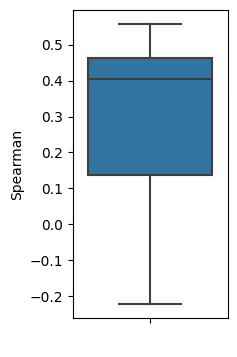

In [12]:
eval_set = np.load('/data/liminghong/sclab/sclab/eval_dataset.npy', allow_pickle=True)
resolution = 10000

_map = {
    "PDGFRA": "OPC", "PTPRZ1": "OPC", "VCAN": "OPC",
    "SLC1A2": "Astro", "SLC1A3": "Astro", "GPM6A": "Astro",
    "MBP": "ODC", "QKI": "ODC", "DOCK10": "ODC", "PIP4K2A": "ODC"
}

splicing_result = pd.DataFrame()
for gene_name in [
    "PDGFRA", "PTPRZ1", "VCAN",  # OPC
    "SLC1A2", "SLC1A3", "GPM6A",  # Astro
    "MBP", "QKI", "DOCK10", "PIP4K2A",  # ODC
]:
    preds = np.load(os.path.join("/data/liminghong/sclab/sclab/tmp", gene_name, "evaluate.npy"), allow_pickle=True)
    _pred, _ = show_by_cell_type(eval_set, preds, cell_type=_map[gene_name], gene_name=gene_name)
    _mat = array2mat(_pred)

    _gene = transcript_info[transcript_info['gene_name']==gene_name]
    start = int(_gene['start'].min()/resolution)
    end = int(_gene['end'].max()/resolution)

    x = []
    for i in range(_mat.shape[0]):
        _test = _mat[i].copy()
        x.append(_test.mean())

    y = np.zeros(_mat.shape[0])
    splicings = pd.DataFrame()
    for root, dirs, files in os.walk("/data/liminghong/sclab/sclab/random_test/SUPPA"):
        for file in files:
            if file.startswith(gene_name) and file.endswith(".ioe"):
                splicing = pd.read_csv(os.path.join(root, file), sep='\t')
                if splicing.shape[0] == 0:
                    continue
                splicing.loc[:, "event"] = file.split('_')[1]
                splicings = pd.concat([splicings, splicing])
    for event in splicings["event"].unique():
        splicing = splicings[splicings["event"]==event]
        for _splicing_info in splicing['event_id'].str.split(':|-'):
            if event == "SE":
                _start, _end = [int(i) for i in _splicing_info[3:5]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "MX":
                _start, _end = [int(i) for i in [_splicing_info[3], _splicing_info[8]]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "A5":
                _start, _end = [int(i) for i in [start * resolution, _splicing_info[2]]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "A3":
                _start, _end = [int(i) for i in [_splicing_info[3], end * resolution]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "RI":
                _start, _end = [int(i) for i in _splicing_info[3:5]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "AF":
                _start, _end = [int(i) for i in [_splicing_info[2], _splicing_info[6]]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start
            elif event == "AL":
                _start, _end = [int(i) for i in [_splicing_info[3], _splicing_info[7]]]
                _start, _end = int(_start / resolution) - start, int(_end / resolution) - start

            if _start < 0 or _end > y.shape[0]:
                continue
            if _start == _end:
                y[_start] += 1
            else:
                y[_start:_end+1] += 1

    _stat, _p = stats.spearmanr(x, y)
    _result = {"r": [_stat], "pvalue": [_p]}
    _result = pd.DataFrame(_result, index=[gene_name])
    splicing_result = pd.concat([splicing_result, _result])

splicing_result.to_csv('table_file/Interaction VS Splicing.csv')
display(splicing_result)

fig = plt.figure(figsize=(2, 4), facecolor='white')

sns.boxplot(data=splicing_result, y="r")
plt.xlabel(" ")
plt.ylabel("Spearman")
plt.savefig('./figure_file/Interaction VS splice(Multiple_genes).pdf', format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_347266/340035010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _result["pearson r"] = _result.mean(axis=1)
/tmp/ipykernel_347266/340035010.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  _result.loc[:, ['chrom', 'start', 'end']] = v19_anno[
/tmp/ipykernel_347266/340035010.py:19: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are 

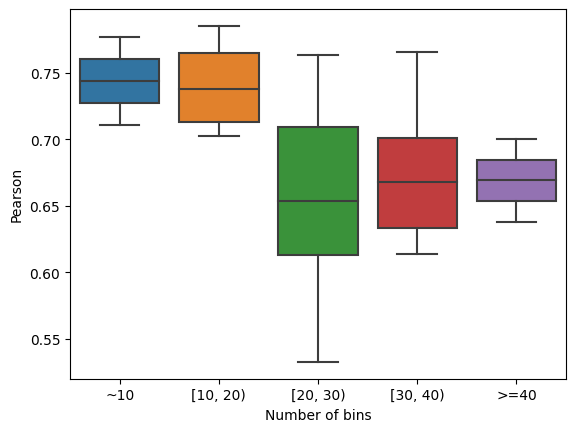

In [13]:
bin_result = pd.DataFrame()

_result = result[["Astro", "Endo", "ODC", "OPC"]]
_result["pearson r"] = _result.mean(axis=1)
_result.loc[:, ['chrom', 'start', 'end']] = _result.reset_index().loc[:, "index"].str.split('_', expand=True).values
_result["bin"] = (_result["end"].astype(int) - _result["start"].astype(int)) / 10000
bin_result = pd.concat([bin_result, _result[["pearson r", "bin"]]])

_result = marker_gene_result[["Astro", "Endo", "ODC", "OPC"]]
_result["pearson r"] = _result.mean(axis=1)
_result.loc[:, ['chrom', 'start', 'end']] = v19_anno[
    (v19_anno["type"]=="gene")&(v19_anno["gene_name"]==v19_anno["transcript_name"])
].set_index("gene_name").loc[_result.index].loc[:, ['chrom', 'start', 'end']].values
_result["bin"] = np.ceil((_result["end"].astype(int) - _result["start"].astype(int)) / 10000)
bin_result = pd.concat([bin_result, _result[["pearson r", "bin"]]])

_result = hk_gene_result[["Astro", "Endo", "ODC", "OPC"]]
_result["pearson r"] = _result.mean(axis=1)
_result.loc[:, ['chrom', 'start', 'end']] = v19_anno[
    (v19_anno["type"]=="gene")&(v19_anno["gene_name"]==v19_anno["transcript_name"])
].set_index("gene_name").loc[_result.index].loc[:, ['chrom', 'start', 'end']].values
_result["bin"] = np.ceil((_result["end"].astype(int) - _result["start"].astype(int)) / 10000)
bin_result = pd.concat([bin_result, _result[["pearson r", "bin"]]])

bin_result.loc[bin_result["bin"]<10, "type"] = "~10"
bin_result.loc[(bin_result["bin"]>=10)&(bin_result["bin"]<20), "type"] = "[10, 20)"
bin_result.loc[(bin_result["bin"]>=20)&(bin_result["bin"]<30), "type"] = "[20, 30)"
bin_result.loc[(bin_result["bin"]>=30)&(bin_result["bin"]<40), "type"] = "[30, 40)"
bin_result.loc[bin_result["bin"]>=40, "type"] = ">=40"
sns.boxplot(data=bin_result, x="type", y="pearson r", order=["~10", "[10, 20)", "[20, 30)", "[30, 40)", ">=40"])
plt.xlabel("Number of bins")
plt.ylabel("Pearson")
plt.savefig('./figure_file/Effect of predicted length.pdf', format='pdf', bbox_inches='tight')
plt.show()

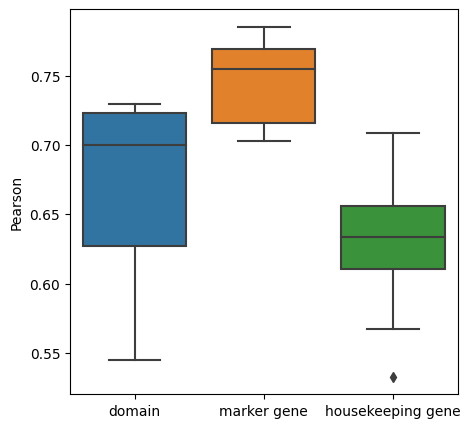

In [14]:
unify_result = pd.DataFrame()

_result = pd.melt(result[["Astro", "Endo", "ODC", "OPC"]].mean(axis=1).to_frame())
_result["type"] = "domain"
unify_result = pd.concat([unify_result, _result])

_result = pd.melt(marker_gene_result[["Astro", "Endo", "ODC", "OPC"]].mean(axis=1).to_frame())
_result["type"] = "marker gene"
unify_result = pd.concat([unify_result, _result])

_result = pd.melt(hk_gene_result[["Astro", "Endo", "ODC", "OPC"]].mean(axis=1).to_frame())
_result["type"] = "housekeeping gene"
unify_result = pd.concat([unify_result, _result])

fig = plt.figure(figsize=(5, 5), facecolor='white')
sns.boxplot(data=unify_result, x="type", y="value")
plt.xlabel("")
plt.ylabel("Pearson")
plt.savefig('./figure_file/Effectiveness.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [15]:
from multiprocessing import Pool

import cooler
import h5py


cerebellum_astro = h5py.File('/data/liminghong/sclab/Astro_bulk_hic/ENCFF027IEO.h5', 'r')
spinal_cord_astro = h5py.File('/data/liminghong/sclab/Astro_bulk_hic/ENCFF715HDW.h5', 'r')

cools_path = "/data/liminghong/sclab/Lee2019/Human_single_cell_10kb_cool"
map_info = pd.read_csv("/data/liminghong/sclab/sclab/map_result.csv", sep='\t', index_col=0)
map_info = map_info[map_info["cell_type"]=="Astro"]

def get_cooler(hic_name):
    for _, _, file_names in os.walk(cools_path):
        for file_name in file_names:
            if hic_name in file_name:
                return hic_name, cooler.Cooler(os.path.join(cools_path, file_name))
    raise Exception("The file could not be found")
with Pool(8) as p:
    _coolers = dict(p.map(get_cooler, map_info["scHiC"]))

In [16]:
def get_bulk_interactions(_bulk, _chr: int, _start: int, _end: int):
    _positions = pd.DataFrame(_bulk['bin_positions'])
    _start_index = _positions[(_positions[0] == _chr)&(_positions[1] == _start)].index[0]
    _end_index = _positions[(_positions[0] == _chr)&(_positions[1] == _end)].index[0]
    return _bulk['interactions'][_start_index:_end_index+1, _start_index:_end_index+1]

def get_sc_interactions(_c, _chr: str, _start: int, _end: int):
    return _c.matrix(balance=False).fetch("{}:{}-{}".format(_chr, _start, _end))

def get_shuffle(_array):
    _where = np.where(np.ones(_array.shape))[0]
    _p = _array / _array.sum()
    _array = np.zeros(_array.shape)
    for i in np.random.choice(_where, int(_array.shape[0]/20), p=_p):
        _array[i] += 1
    return _array

def _reshape(_mat, _schic_range, _bulk_shape, _bulk_range):
    _reshape_mat = np.zeros(_bulk_shape)
    for i in range(len(_bulk_range)):
        _start1, _end1 = _bulk_range[i], _bulk_range[i] + 40000
        _range1 = np.where((np.array(_schic_range)>=_start1)&(np.array(_schic_range)<_end1))[0]
        _part_mat1 = _mat[_range1]
        for j in range(i, len(_bulk_range)):
            _start2, _end2 = _bulk_range[j], _bulk_range[j] + 40000
            _range2 = np.where((np.array(_schic_range)>=_start2)&(np.array(_schic_range)<_end2))[0]
            _part_mat2 = _part_mat1[:, _range2]
            _reshape_mat[i, j] = _part_mat2.mean()
        
    _reshape_mat = _reshape_mat + np.triu(_reshape_mat, k=1).T
    return _reshape_mat

def cal_pearson(_schic, _schic_range, _bulk, _bulk_range, _nums):
    _array = np.zeros(_schic[0].shape)
    for i in range(_nums):
        _array += get_shuffle(_schic[i])
    _mat = array2mat(_array)
    
    _reshape_mat = _reshape(_mat, _schic_range, _bulk.shape, _bulk_range)
    
    return stats.pearsonr(_reshape_mat.reshape(-1), _bulk.reshape(-1))[0]

In [17]:
positions = pd.DataFrame(cerebellum_astro['bin_positions'])
number = 0
cerebellum_pearsons, spinal_cord_pearsons = [], []
while number < 10:
    random_position = positions.sample(random_state=0)
    _bulk_chrom, _bulk_start, _ = random_position.values[0]
    _index = random_position.index[0]
    if positions.iloc[_index+25].values[0] != _bulk_chrom:
        # 1M later, chrom different
        continue
    _bulk_end = positions.iloc[_index+25].values[1]
    cerebellum_interactions = get_bulk_interactions(cerebellum_astro, _chr=_bulk_chrom, _start=_bulk_start, _end=_bulk_end-40000)
    spinal_cord_interactions = get_bulk_interactions(spinal_cord_astro, _chr=_bulk_chrom, _start=_bulk_start, _end=_bulk_end-40000)

    cerebellum_interactions = np.nan_to_num(cerebellum_interactions)
    spinal_cord_interactions = np.nan_to_num(spinal_cord_interactions)

    _sc_chrom, _sc_start, _sc_end = "chr{}".format(_bulk_chrom+1), _bulk_start-1, _bulk_end-1
    _schic_range = list(range(_sc_start, _sc_end, 10000))
    _bulk_range = list(range(_bulk_start, _bulk_end, 40000))
    _schic = [mat2array(get_sc_interactions(_c, _sc_chrom, _sc_start, _sc_end)) for _c in _coolers.values()]
    
    cerebellum_pearsons.append([
        cal_pearson(_schic, _schic_range, cerebellum_interactions, _bulk_range, i)
        for i in range(1, 61)
    ])
    spinal_cord_pearsons.append([
        cal_pearson(_schic, _schic_range, spinal_cord_interactions, _bulk_range, i)
        for i in range(1, 61)
    ])

    number += 1

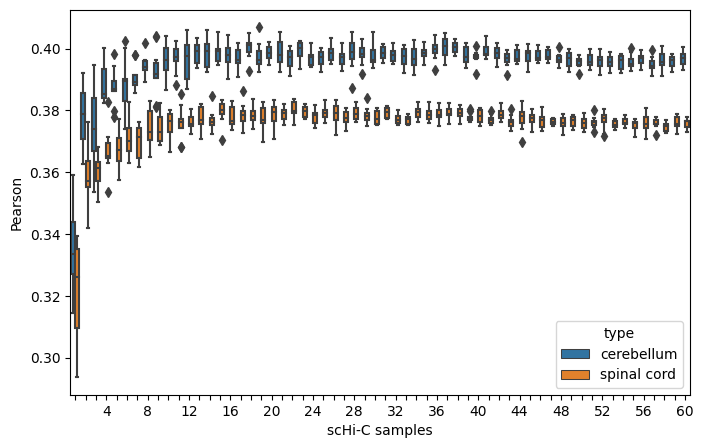

In [18]:
_cerebellum_pearsons, _spinal_cord_pearsons = pd.melt(pd.DataFrame(cerebellum_pearsons)), pd.melt(pd.DataFrame(spinal_cord_pearsons))
_cerebellum_pearsons["type"], _spinal_cord_pearsons["type"] = "cerebellum", "spinal cord"
_cerebellum_pearsons["variable"], _spinal_cord_pearsons["variable"] = _cerebellum_pearsons["variable"]+1, _spinal_cord_pearsons["variable"]+1

fig = plt.figure(figsize=(8, 5), facecolor='white')
ax = sns.boxplot(data=pd.concat([_cerebellum_pearsons, _spinal_cord_pearsons]), x="variable", y="value", hue="type")

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if int(label.get_text()) % 4 != 0:
        label.set_visible(False)

plt.xlabel("scHi-C samples")
plt.ylabel("Pearson")
plt.savefig('./figure_file/single vs bulk(random location).pdf', format='pdf', bbox_inches='tight')
plt.show()